In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

In [258]:
# Importing the data and adding the full_name of the athletes
ifsc_df = pd.read_csv('IFSC_Results.csv')
ifsc_df['athlete_full_name']  = ifsc_df['Athlete First Name'] + ' ' + ifsc_df['Athlete Last Name']
#ifsc_df.head()

# Creating a side table for athlete info and ID
unique_names = ifsc_df['athlete_full_name'].unique()
athletes_df = pd.DataFrame({'athlete_full_name':unique_names})
athletes_df = athletes_df.sort_values(by='athlete_full_name').reset_index(drop=True)
athletes_df['athlete_id'] = range(101, len(athletes_df['athlete_full_name']) + 101)
#athletes_df.head()

# Creating a side table for competition info
competition_df = ifsc_df[['Competition']].drop_duplicates().reset_index(drop=True)
competition_df['year'] = competition_df['Competition'].str.extract(r'(\d{4})')
competition_df = competition_df.sort_values(by='year').reset_index(drop=True)
competition_df['competition_id']= range(1001, len(competition_df['Competition']) + 1001)
#competition_df.head()

# Same for the type of competition. We only have 3 Boulder&Lead, Boulder, Lead
competition_type_df =  ifsc_df[['Type']].drop_duplicates().reset_index(drop=True)
competition_type_df['competition_type_id']= range(1, len(competition_type_df['Type']) + 1)
#competition_type_df

# Bring all the ids back to the original df
ifsc_df = ifsc_df.merge(athletes_df, on='athlete_full_name', how='left')
ifsc_df = ifsc_df.merge(competition_df, on='Competition', how='left')
ifsc_df = ifsc_df.merge(competition_type_df, on='Type', how='left')
#ifsc_df.head()

# Creating a short version of the dataframe for classification purposes
short_version_columns = ['actual_rank','athlete_id','competition_id','competition_type_id']
ifsc_short_df = ifsc_df.loc[:,short_version_columns]
# ifsc_short_df.head()

# We only keep the boulder & lead comps for now
b_and_l_short_df = ifsc_short_df[ifsc_short_df['competition_type_id']==1]
b_and_l_short_df = b_and_l_short_df.drop('competition_type_id',axis=1)
# b_and_l_short_df.head()

### Ranker model training

Train test split with group shuffle. The query id is the competition id (we have the relative rank by competition). The target value is the rank.

In [260]:
# We try to modelise and predict the rank - 1. first we do a train test split with group shuffle
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(b_and_l_short_df, groups=b_and_l_short_df['competition_id'])

X_train_inds, X_test_inds = next(gss)

train_data= b_and_l_short_df.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['competition_id','actual_rank'])]
y_train = train_data.loc[:, train_data.columns.isin(['actual_rank'])]

groups = train_data.groupby('competition_id').size().to_frame('size')['size'].to_numpy()

test_data= b_and_l_short_df.iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['actual_rank'])]
y_test = test_data.loc[:, test_data.columns.isin(['actual_rank'])]

We build the model with XGB Ranker. We will need to try and rfine/tune the parameters.

In [261]:
# 2. we build the ranking model with xgboost ranker
import xgboost as xgb

model = xgb.XGBRanker(  
   # tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )

model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.9,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eta=0.05, eval_metric=None, feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=110,
          n_jobs=None, num_parallel_tree=None, ...)

We predict with the model on the entire database. This gives us prediction scores which we can then rank based on their values from one to another.

In [262]:
# Predicting on the whole df using the model
predictions = model.predict(b_and_l_short_df.loc[:, ~b_and_l_short_df.columns.isin(['actual_rank','competition_id'])])
# print(predictions.shape)  # confirms we have predictions for the whole original df as an array
# print(predictions) # relative score for each individual entry

# Adding the predicted_score to the df for boulder and lead
b_and_l_short_df['predicted_score'] = predictions

# Adding the predicted rank, based on the score, in a nested way, restarting at every competition_id
# Sort the DataFrame by competition_id and predicted_scores in ascending order
b_and_l_short_df_sorted = b_and_l_short_df.sort_values(['competition_id', 'predicted_score'], ascending=[True, True])

# Group the DataFrame by competition_id and calculate the ranks within each group
b_and_l_short_df_sorted['predicted_rank'] = b_and_l_short_df_sorted.groupby('competition_id')['predicted_score'].rank(ascending=True)

# Adding back the athlete name and competition details, removing ids and score for clarity and presentation
b_and_l_df = b_and_l_short_df_sorted.merge(athletes_df, on = 'athlete_id', how='left').merge(competition_df, on ='competition_id', how='left')
columns_for_presentation = ['Competition', 'year','athlete_full_name','actual_rank', 'predicted_rank']
b_and_l_df_summary = b_and_l_df[columns_for_presentation]
b_and_l_df_summary

,Competition,year,athlete_full_name,actual_rank,predicted_rank
0,"IFSC Europe - Continental Championships (B,S,L...",2022,Janja Garnbret,1,1.5
1,"IFSC Europe - Continental Championships (B,S,L...",2022,Jessica Pilz,3,1.5
2,"IFSC Europe - Continental Championships (B,S,L...",2022,Ievgeniia Kazbekova,6,3.0
3,"IFSC Europe - Continental Championships (B,S,L...",2022,Mia Krampl,2,4.0
4,"IFSC Europe - Continental Championships (B,S,L...",2022,Camilla Moroni,7,5.0
...,...,...,...,...,...
265,Olympic Qualifier Series Shanghai 2024,2024,Maria Aguado,38,44.0
266,Olympic Qualifier Series Shanghai 2024,2024,Maya Stasiuk,28,45.0
267,Olympic Qualifier Series Shanghai 2024,2024,Sandra Hopfensitz,39,46.0
268,Olympic Qualifier Series Shanghai 2024,2024,Svana Bjarnason,47,47.0


In [263]:
# Adding data for a future hypothethical competition, to see how the model performs
future_comp = [
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Oriane Bertone' ,'actual_rank': np.nan, 'predicted_rank': np.nan },
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Janja Garnbret' ,'actual_rank': np.nan, 'predicted_rank': np.nan },
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Natalia Grossman' ,'actual_rank': np.nan, 'predicted_rank': np.nan },
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Brooke Raboutou' ,'actual_rank': np.nan, 'predicted_rank': np.nan },
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Ai Mori' ,'actual_rank': np.nan, 'predicted_rank': np.nan },
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Jessica Pilz' ,'actual_rank': np.nan, 'predicted_rank': np.nan },
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Laura Rogora' ,'actual_rank': np.nan, 'predicted_rank': np.nan },
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Miho Nonaka' ,'actual_rank': np.nan, 'predicted_rank': np.nan },
    {'Competition': 'Future Competition', 'year':2024,'athlete_full_name': 'Chaehyun Seo' ,'actual_rank': np.nan, 'predicted_rank': np.nan }
]
# Create a new DataFrame from the new rows
future_comp_df = pd.DataFrame(future_comp)

# Adding the new com to the competition df
future_comp_info = {'Competition': 'Future Competition', 'year':2024, 'competition_id' :9999}
future_comp_info_df = pd.DataFrame(future_comp_info,index=[0])
competition_df = pd.concat([competition_df, future_comp_info_df],ignore_index=True)

# Append the new DataFrame to the existing DataFrame
b_and_l_df_summary = pd.concat([b_and_l_df_summary,future_comp_df] , ignore_index=True)
b_and_l_df_summary

,Competition,year,athlete_full_name,actual_rank,predicted_rank
0,"IFSC Europe - Continental Championships (B,S,L...",2022,Janja Garnbret,1.0,1.5
1,"IFSC Europe - Continental Championships (B,S,L...",2022,Jessica Pilz,3.0,1.5
2,"IFSC Europe - Continental Championships (B,S,L...",2022,Ievgeniia Kazbekova,6.0,3.0
3,"IFSC Europe - Continental Championships (B,S,L...",2022,Mia Krampl,2.0,4.0
4,"IFSC Europe - Continental Championships (B,S,L...",2022,Camilla Moroni,7.0,5.0
...,...,...,...,...,...
274,Future Competition,2024,Ai Mori,NaN,NaN
275,Future Competition,2024,Jessica Pilz,NaN,NaN
276,Future Competition,2024,Laura Rogora,NaN,NaN
277,Future Competition,2024,Miho Nonaka,NaN,NaN


In [264]:
# Preparing the short df with just the future comp and the necessary field to make the predictions
b_and_l_future_comp_df =  b_and_l_df_summary[b_and_l_df_summary['Competition']=='Future Competition'].merge(athletes_df, on='athlete_full_name', how='left').merge(competition_df, on = ['Competition','year'], how='left')
b_and_l_future_comp_short_df = b_and_l_future_comp_df.drop(columns=['Competition','year', 'athlete_full_name','predicted_rank'],axis=1)

# Predicting on the new df using the model
predictions_future_comp = model.predict(b_and_l_future_comp_short_df.loc[:, ~b_and_l_future_comp_short_df.columns.isin(['actual_rank','competition_id'])])

# Adding the predicted_score to the df for boulder and lead
b_and_l_future_comp_short_df['predicted_score'] = predictions_future_comp

# Adding the predicted rank, based on the score, for this future comp
b_and_l_future_comp_short_df_sorted = b_and_l_future_comp_short_df.sort_values(['competition_id', 'predicted_score'], ascending=[True, True])
b_and_l_future_comp_short_df_sorted['predicted_rank'] = b_and_l_future_comp_short_df_sorted.groupby('competition_id')['predicted_score'].rank(ascending=True)

# Adding back the results to the b_and_l df and b_and_l df summary
b_and_l_df = pd.concat([b_and_l_df,b_and_l_future_comp_short_df_sorted.merge(athletes_df, on = 'athlete_id', how='left').merge(competition_df, on ='competition_id', how='left')],ignore_index=True)
b_and_l_df_summary = b_and_l_df[columns_for_presentation]
b_and_l_df_summary[b_and_l_df_summary['Competition']=='Future Competition']

,Competition,year,athlete_full_name,actual_rank,predicted_rank
270,Future Competition,2024,Oriane Bertone,NaN,1.0
271,Future Competition,2024,Brooke Raboutou,NaN,2.0
272,Future Competition,2024,Janja Garnbret,NaN,3.5
273,Future Competition,2024,Jessica Pilz,NaN,3.5
274,Future Competition,2024,Miho Nonaka,NaN,5.0
275,Future Competition,2024,Chaehyun Seo,NaN,6.0
276,Future Competition,2024,Laura Rogora,NaN,7.0
277,Future Competition,2024,Ai Mori,NaN,8.0
278,Future Competition,2024,Natalia Grossman,NaN,9.0


#### Calculating and predicting results on bouldering and lead separately

In [265]:
# Writing a function to do the boulder text format score sheet conversion to a boulder and lead type score
score_for_top = 25
score_for_zone = 10
score_deduction = 0.1

def boulder_score_conversion(df, comp_phase):
    # Get the column corresponding the competition phase that we need to transform
    col_name = df['score_'+comp_phase].name
    # Create a mask to identify non-null entries
    mask = df[col_name].notnull()
    # Transform the text string containing the score into a 4 integers. There should always be 4 integers, in that format (tops, zones, top attempts, zone attempts)
    extracted = df[mask][col_name].str.extract(r'(?P<int1>\d+)\D+(?P<int2>\d+)\D+(?P<int3>\d+)\D+(?P<int4>\d+)')
    df[comp_phase + '_tops'] = extracted['int1'].astype(int)
    df[comp_phase + '_zones'] = extracted['int2'].astype(int)
    df[comp_phase + '_top_attempts'] = extracted['int3'].astype(int)
    df[comp_phase + '_zone_attempts'] = extracted['int4'].astype(int)
    
    # Calculating the failed top and zone attempts, which incur a deduction of 0.1 each
    df[comp_phase + '_deduction_top_attempts'] = df[comp_phase + '_top_attempts'] - df[comp_phase + '_tops'] 
    df[comp_phase + '_deduction_zone_attempts'] = df[comp_phase + '_zone_attempts'] - df[comp_phase + '_zones']
    
    # Calculating the final score
    df[comp_phase + '_zone_not_top'] = df[comp_phase + '_zones'] - df[comp_phase + '_tops']
    df[comp_phase + '_converted_score'] = score_for_top * df[comp_phase + '_tops'] + score_for_zone * df[comp_phase + '_zone_not_top'] - (df[comp_phase + '_deduction_top_attempts'] + df[comp_phase + '_deduction_zone_attempts']) * score_deduction


In [266]:
# Writing a function to do the conversion of the lead score (number of moves) to a boulder and lead type score
max_nb_moves_lead = 43
top_of_points_scale_lead = 40
points_per_move_1_to_10 = 1
points_per_move_11_to_20 = 2
points_per_move_21_to_30 = 3
points_per_move_31_to_40 = 4

def lead_score_conversion(df, comp_phase):
    # Get the column corresponding the competition phase that we need to transform
    col_name = df['score_'+comp_phase].name
    # Create a mask to identify non-null entries
    mask = df[col_name].notnull()
    # Assuming all competition have the same number of maximum moves (set in the parameter above)
    df[comp_phase + '_moves_for_score'] = df[col_name] - (max_nb_moves_lead - top_of_points_scale_lead)
    df[comp_phase + '_converted_score'] = (df[comp_phase + '_moves_for_score'].apply(lambda x: max(x - 30, 0))) * points_per_move_31_to_40 \
        + (df[comp_phase + '_moves_for_score'].apply(lambda x: min(10, max(x - 20, 0)))) * points_per_move_21_to_30 \
            + (df[comp_phase + '_moves_for_score'].apply(lambda x: min(10, max(x - 10, 0)))) * points_per_move_11_to_20 \
                + (df[comp_phase + '_moves_for_score'].apply(lambda x: min(10, max(x - 0, 0)))) * points_per_move_1_to_10

In [267]:
# Computing the boulder and lead type scores
boulder_comp_phases = ['qualification_boulder','sf_boulder','final_boulder']
lead_comp_phases = ['qualification_lead','sf_lead','final_lead']
for phase in boulder_comp_phases:
    boulder_score_conversion(ifsc_df, phase)
for phase in lead_comp_phases:
    lead_score_conversion(ifsc_df, phase)

In [268]:
# Presenting them in the total database
cols_to_drop_for_ifsc_df_summary = [ 'score_qualification_boulder', 'score_sf_boulder',       'score_final_boulder', 'score_qualification_lead', 'score_sf_lead',       'score_final_lead', 'athlete_full_name', 'athlete_id',
       'competition_id', 'competition_type_id', 'qualification_boulder_tops',
       'qualification_boulder_zones', 'qualification_boulder_top_attempts',
       'qualification_boulder_zone_attempts',
       'qualification_boulder_deduction_top_attempts',
       'qualification_boulder_deduction_zone_attempts',
       'qualification_boulder_zone_not_top', 'sf_boulder_tops',
       'sf_boulder_zones', 'sf_boulder_top_attempts',
       'sf_boulder_zone_attempts', 'sf_boulder_deduction_top_attempts',
       'sf_boulder_deduction_zone_attempts', 'sf_boulder_zone_not_top', 'final_boulder_tops',
       'final_boulder_zones', 'final_boulder_top_attempts',
       'final_boulder_zone_attempts', 'final_boulder_deduction_top_attempts',
       'final_boulder_deduction_zone_attempts', 'final_boulder_zone_not_top', 'qualification_lead_moves_for_score',
        'sf_lead_moves_for_score', 'final_lead_moves_for_score',]
ifsc_df_summary = ifsc_df.drop(columns=cols_to_drop_for_ifsc_df_summary , axis = 1)
ifsc_df_summary.head()

,Competition,Type,actual_rank,Athlete First Name,Athlete Last Name,score_qualification_B&L,score_sf_B&L,score_final_B&L,year,qualification_boulder_converted_score,sf_boulder_converted_score,final_boulder_converted_score,qualification_lead_converted_score,sf_lead_converted_score,final_lead_converted_score
0,IFSC European Qualifier Laval 2023,Boulder&lead,1,Oriane,Bertone,199.9,144.2,171.9,2023,NaN,NaN,NaN,NaN,NaN,NaN
1,IFSC European Qualifier Laval 2023,Boulder&lead,2,Stasa,Gejo,NaN,NaN,NaN,2023,NaN,NaN,NaN,NaN,NaN,NaN
2,IFSC European Qualifier Laval 2023,Boulder&lead,3,Laura,Rogora,NaN,NaN,NaN,2023,NaN,NaN,NaN,NaN,NaN,NaN
3,IFSC European Qualifier Laval 2023,Boulder&lead,4,Ievgeniia,Kazbekova,NaN,NaN,NaN,2023,NaN,NaN,NaN,NaN,NaN,NaN
4,IFSC European Qualifier Laval 2023,Boulder&lead,5,Zelia,Avezou,NaN,NaN,NaN,2023,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
# Visualizing an example, the Tokyo 2020 Olympics finals, and calculating what whould have been the final results with boulder and lead score rules

# Get the events of the olympics comp
tokyo_2020 = ifsc_df_summary[ifsc_df_summary['Competition'].isin(['Olympics Tokyo 2021 - Qualifications - Women','Olympics Tokyo 2021 - Finals - Women'])].copy()
# Keep the columns needed and group by athlete
tokyo_2020_boulder_and_lead = tokyo_2020.drop(['Competition','Type','actual_rank','score_qualification_B&L', 'score_sf_B&L','score_final_B&L', 'year',],axis=1)
tokyo_2020_boulder_and_lead = tokyo_2020_boulder_and_lead.groupby(['Athlete First Name','Athlete Last Name']).sum().reset_index()
# Compute the B&L scores 
tokyo_2020_boulder_and_lead['qualification_B&L_recalculated'] = tokyo_2020_boulder_and_lead['qualification_boulder_converted_score'] + tokyo_2020_boulder_and_lead['qualification_lead_converted_score']
tokyo_2020_boulder_and_lead['final_B&L_recalculated'] = tokyo_2020_boulder_and_lead['final_boulder_converted_score'] + tokyo_2020_boulder_and_lead['final_lead_converted_score']
# Drop the unnecessary sf columns  
tokyo_2020_boulder_and_lead = tokyo_2020_boulder_and_lead.drop(['sf_boulder_converted_score', 'sf_lead_converted_score'],axis=1)
# Compute the ranks for quali 
tokyo_2020_boulder_and_lead['qualification_B&L_recalculated_rank'] = tokyo_2020_boulder_and_lead['qualification_B&L_recalculated'].rank(ascending=False).astype(int)
# Compute ranks for the final
tokyo_2020_boulder_and_lead['final_B&L_recalculated_rank'] = np.nan
tokyo_2020_final_boulder_and_lead_rank_mask = (tokyo_2020_boulder_and_lead['final_B&L_recalculated'] != 0) & (tokyo_2020_boulder_and_lead['final_B&L_recalculated'].notnull())
tokyo_2020_boulder_and_lead.loc[tokyo_2020_final_boulder_and_lead_rank_mask, 'final_B&L_recalculated_rank'] = tokyo_2020_boulder_and_lead.loc[tokyo_2020_final_boulder_and_lead_rank_mask, 'final_B&L_recalculated'].rank(ascending=False).astype(int)

# Manually creating the actual classification of the olympics
tokyo_2020_actual_classification = tokyo_2020[['Athlete First Name','Athlete Last Name']].groupby(['Athlete First Name','Athlete Last Name']).min().reset_index()
tokyo_2020_actual_classification['qualification_actual_rank'] = [4,14,7,8,5,2,20,17,1,6,13,11,15,18,3,19,16,10,12,9]
tokyo_2020_actual_classification['final_actual_rank'] = [3, np.nan, 4, 6,5,8,np.nan,np.nan,1,7,np.nan,np.nan,np.nan,np.nan,2,np.nan,np.nan,np.nan,np.nan,np.nan]

# Adding the actual ranks of the olympics to our df
tokyo_2020_boulder_and_lead = tokyo_2020_boulder_and_lead.merge(tokyo_2020_actual_classification,on=['Athlete First Name','Athlete Last Name'])

# Displaying results of quali
tokyo_2020_columns_for_quali = ['Athlete First Name', 'Athlete Last Name','qualification_boulder_converted_score','qualification_lead_converted_score','qualification_B&L_recalculated','qualification_B&L_recalculated_rank','qualification_actual_rank']
tokyo_2020_boulder_and_lead_quali = tokyo_2020_boulder_and_lead[tokyo_2020_columns_for_quali].sort_values(by='qualification_B&L_recalculated_rank', ascending = True)

# Adding the rank difference, color coding them and adding the medal color for final actual placement
tokyo_2020_boulder_and_lead_quali['rank_difference'] = tokyo_2020_boulder_and_lead_quali['qualification_B&L_recalculated_rank'] - tokyo_2020_boulder_and_lead_quali['qualification_actual_rank']
# Formatting the rank difference with a +/- sign for display
tokyo_2020_boulder_and_lead_quali['rank_difference_text'] = tokyo_2020_boulder_and_lead_quali['rank_difference'].apply(lambda x: f"+{x}" if x > 0 else str(x))
    # Define a color map for the rank differences
cmap_rank_differences = {'Super-Robbed': 'orangered', 'Robbed': 'orange', 'Overperformed': 'dodgerblue','Super-Overperformed': 'turquoise', 'No change': 'grey'}
    # Assign colors based on the rank differences
tokyo_2020_boulder_and_lead_quali['color'] = np.where(tokyo_2020_boulder_and_lead_quali['rank_difference'] < -3, 'Super-Robbed',\
                                                      np.where(tokyo_2020_boulder_and_lead_quali['rank_difference'] < 0, 'Robbed',\
                                                                np.where(tokyo_2020_boulder_and_lead_quali['rank_difference'] == 0, 'No change',\
                                                                np.where(tokyo_2020_boulder_and_lead_quali['rank_difference'] < 4, 'Overperformed', 'Super-Overperformed'))))
    # Assign medals based on the actual ranks
tokyo_2020_boulder_and_lead_quali['qualified'] = np.where(tokyo_2020_boulder_and_lead_quali['qualification_actual_rank'] <= 8, 'qualified', 'not_qualified')
    # Define a color map for the medals
cmap_qualified = {'qualified': 'limegreen', 'not_qualified': 'red'}

tokyo_2020_boulder_and_lead_quali.head()

,Athlete First Name,Athlete Last Name,qualification_boulder_converted_score,qualification_lead_converted_score,qualification_B&L_recalculated,qualification_B&L_recalculated_rank,qualification_actual_rank,rank_difference,rank_difference_text,color,qualified
5,Chaehyun,Seo,69.6,88.0,157.6,1,2,-1,-1,Robbed,qualified
8,Janja,Garnbret,100.0,51.0,151.0,2,1,1,+1,Overperformed,qualified
0,Akiyo,Noguchi,84.8,42.0,126.8,3,4,-1,-1,Robbed,qualified
4,Brooke,Raboutou,84.9,39.0,123.9,4,5,-1,-1,Robbed,qualified
18,Viktoria,Meshkova,69.3,48.0,117.3,5,12,-7,-7,Super-Robbed,not_qualified


In [270]:
# Displaying results of final
tokyo_2020_columns_for_quali = ['Athlete First Name', 'Athlete Last Name','final_boulder_converted_score','final_lead_converted_score','final_B&L_recalculated','final_B&L_recalculated_rank','final_actual_rank']
tokyo_2020_boulder_and_lead_final = tokyo_2020_boulder_and_lead[~tokyo_2020_boulder_and_lead['final_actual_rank'].isnull()][tokyo_2020_columns_for_quali].sort_values(by='final_B&L_recalculated_rank', ascending = True)
tokyo_2020_boulder_and_lead_final['final_B&L_recalculated_rank'] = tokyo_2020_boulder_and_lead_final['final_B&L_recalculated_rank'].astype(int)
tokyo_2020_boulder_and_lead_final['final_actual_rank'] = tokyo_2020_boulder_and_lead_final['final_actual_rank'].astype(int)
tokyo_2020_boulder_and_lead_final[tokyo_2020_columns_for_quali].sort_values(by='final_B&L_recalculated_rank', ascending = True)

# Adding the rank difference, color coding them and adding the medal color for final actual placement
tokyo_2020_boulder_and_lead_final['rank_difference'] = tokyo_2020_boulder_and_lead_final['final_B&L_recalculated_rank'] - tokyo_2020_boulder_and_lead_final['final_actual_rank']
# Formatting the rank difference with a +/- sign for display
tokyo_2020_boulder_and_lead_final['rank_difference_text'] = tokyo_2020_boulder_and_lead_final['rank_difference'].apply(lambda x: f"+{x}" if x > 0 else str(x))

    # Assign colors based on the rank differences
tokyo_2020_boulder_and_lead_final['color'] = np.where(tokyo_2020_boulder_and_lead_final['rank_difference'] < -3, 'Super-Robbed',\
                                                      np.where(tokyo_2020_boulder_and_lead_final['rank_difference'] < 0, 'Robbed',\
                                                                np.where(tokyo_2020_boulder_and_lead_final['rank_difference'] == 0, 'No change',\
                                                                np.where(tokyo_2020_boulder_and_lead_final['rank_difference'] < 4, 'Overperformed', 'Super-Overperformed'))))
    # Assign medals based on the actual ranks
tokyo_2020_boulder_and_lead_final['medal'] = np.where(tokyo_2020_boulder_and_lead_final['final_actual_rank'] == 1, 'gold', np.where(tokyo_2020_boulder_and_lead_final['final_actual_rank'] == 2, 'silver', np.where(tokyo_2020_boulder_and_lead_final['final_actual_rank'] == 3, 'bronze', 'no_medal')))
    # Define a color map for the medals
cmap_medals = {'gold': 'gold', 'silver': 'silver', 'bronze':'brown', 'no_medal': 'black'}

tokyo_2020_boulder_and_lead_final

,Athlete First Name,Athlete Last Name,final_boulder_converted_score,final_lead_converted_score,final_B&L_recalculated,final_B&L_recalculated_rank,final_actual_rank,rank_difference,rank_difference_text,color,medal
8,Janja,Garnbret,59.7,76.0,135.7,1,1,0,0,No change,gold
9,Jessica,Pilz,19.2,64.0,83.2,2,7,-5,-5,Super-Robbed,no_medal
5,Chaehyun,Seo,0.0,68.0,68.0,3,8,-5,-5,Super-Robbed,no_medal
0,Akiyo,Noguchi,19.5,48.0,67.5,4,3,1,+1,Overperformed,bronze
4,Brooke,Raboutou,29.3,24.0,53.3,5,5,0,0,No change,no_medal
14,Miho,Nonaka,19.7,26.0,45.7,6,2,4,+4,Super-Overperformed,silver
3,Anouck,Jaubert,9.9,10.0,19.9,7,6,1,+1,Overperformed,no_medal
2,Aleksandra,Miroslaw,0.0,6.0,6.0,8,4,4,+4,Super-Overperformed,no_medal


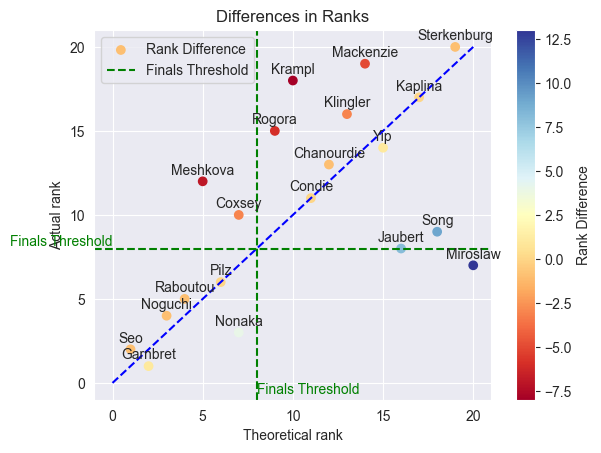

In [271]:
# Calculate the difference in ranks
tokyo_2020_boulder_and_lead_quali['rank_diff'] = tokyo_2020_boulder_and_lead_quali['qualification_B&L_recalculated_rank'] - tokyo_2020_boulder_and_lead_quali['qualification_actual_rank']

# Create a scatter plot of the differences in ranks
plt.scatter(tokyo_2020_boulder_and_lead_quali['qualification_B&L_recalculated_rank'], tokyo_2020_boulder_and_lead_quali['qualification_actual_rank'],c=tokyo_2020_boulder_and_lead_quali['rank_diff'], cmap='RdYlBu', label='Rank Difference')
cbar = plt.colorbar()
cbar.set_label('Rank Difference')

# Set the x-axis and y-axis tick marks to integers
plt.xticks(range(0, 21, 5))
plt.yticks(range(0, 21, 5))

# Add a dashed line corresponding to rank1=rank2
plt.plot([0, 20], [0, 20], 'b--')

# Add a horizontal and vertical bar corresponding to rank = 8
plt.axhline(y=8, color='g', linestyle='--', label='Finals Threshold')
plt.axvline(x=8, color='g', linestyle='--')

# Annotate the horizontal and vertical bar with "Finals Threshold"
plt.text(0, 8, 'Finals Threshold', ha='right', va='bottom', color='g')
plt.text(8, 0, 'Finals Threshold', ha='left', va='top', color='g')

# Annotate the points with athlete names
for i, row in tokyo_2020_boulder_and_lead_quali.iterrows():
    plt.annotate(row['Athlete Last Name'], (row['qualification_B&L_recalculated_rank'], row['qualification_actual_rank']), textcoords="offset points", xytext=(0, 5), ha='center')

# Add labels and title to the plot
plt.xlabel('Theoretical rank')
plt.ylabel('Actual rank')
plt.title('Differences in Ranks')

# Show a legend
plt.legend()

# Show the plot
plt.show()

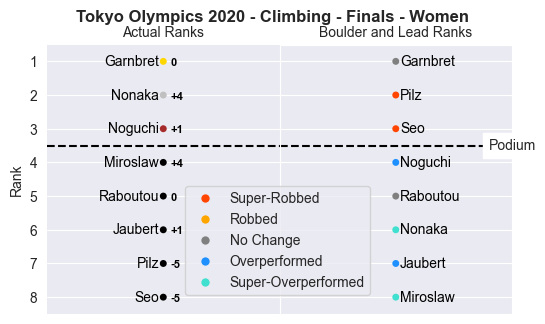

In [280]:
# Set the plot style to 'whitegrid'
sns.set_style('darkgrid')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.5), sharey=True)

# Plot the actual ranks on the left subplot
sns.swarmplot(data=tokyo_2020_boulder_and_lead_final, y='final_actual_rank', ax=ax1, hue='medal', palette=cmap_medals)
for i, row in tokyo_2020_boulder_and_lead_final.iterrows():
    ax1.annotate(row['Athlete Last Name'], (0,row['final_actual_rank']), textcoords="offset points", xytext=(-3, -3), ha='right', color='black')

# Set the labels and title for the left subplot
ax1.set_ylabel('Rank')
ax1.set_title('Actual Ranks', fontsize = 10)
# Remove the legend for the first chart
ax1.legend_.remove()
# Remove the box around the left subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Plot the predicted ranks on the right subplot
sns.swarmplot(data=tokyo_2020_boulder_and_lead_final, y='final_B&L_recalculated_rank', ax=ax2,  hue='color',palette=cmap_rank_differences)

    # if some points (athletes ex aequo) we need to offset the names the displayed
temp_list_ranks = []
xytext_name_normal = (3,-3)
xytext_name_offset = (3, -13)
xytext_rankdiff_normal = (5,-3)
for i, row in tokyo_2020_boulder_and_lead_final.iterrows():
    ax2.annotate(row['Athlete Last Name'], (0,row['final_B&L_recalculated_rank']), textcoords="offset points", xytext= xytext_name_offset if row['final_B&L_recalculated_rank'] in temp_list_ranks else xytext_name_normal ,\
                  ha='left', color='black')
    ax1.annotate(row['rank_difference_text'], (0,row['final_actual_rank']), textcoords="offset points", xytext=xytext_rankdiff_normal, ha='left', color='black',fontsize = 8, fontweight = 'bold')
    temp_list_ranks.append(row['final_B&L_recalculated_rank'])

del temp_list_ranks

# Set the labels and title for the right subplot
ax2.set_title('Boulder and Lead Ranks', fontsize = 10)

# Create custom legend circle markers in the desired order
legend_circles = [
    Line2D([0], [0], marker='o', color='#eaeaf2', label='Super-Robbed', markerfacecolor='orangered', markersize=7),
    Line2D([0], [0], marker='o', color='#eaeaf2', label='Robbed', markerfacecolor='orange', markersize=7),
    Line2D([0], [0], marker='o', color='#eaeaf2', label='No Change', markerfacecolor='grey', markersize=7),
    Line2D([0], [0], marker='o', color='#eaeaf2', label='Overperformed', markerfacecolor='dodgerblue', markersize=7),
    Line2D([0], [0], marker='o', color='#eaeaf2', label='Super-Overperformed', markerfacecolor='turquoise', markersize=7),
]
# Move the legend box more to the left
ax2.legend(title='',handles=legend_circles,  bbox_to_anchor=(0.42, 0.5))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

# Add a horizontal dashed line at y = 3.5 with the annotation "podium"
for ax in [ax1, ax2]:
    ax.axhline(y=3.5, color='black', linestyle='--')
    
ax2.text(0.5, 3.5, 'Podium', ha='center', va='center', backgroundcolor='white')

# Reverse the order of the y-axis
ax1.set_ylim(8.5,0.5)
ax2.set_ylim(8.5,0.5)

# Show the plot
#plt.tight_layout()
title = 'Tokyo Olympics 2020 - Climbing - Finals - Women'
plt.suptitle(title, fontsize = 12, fontweight = 'bold')
plt.show()
fig.savefig(title)

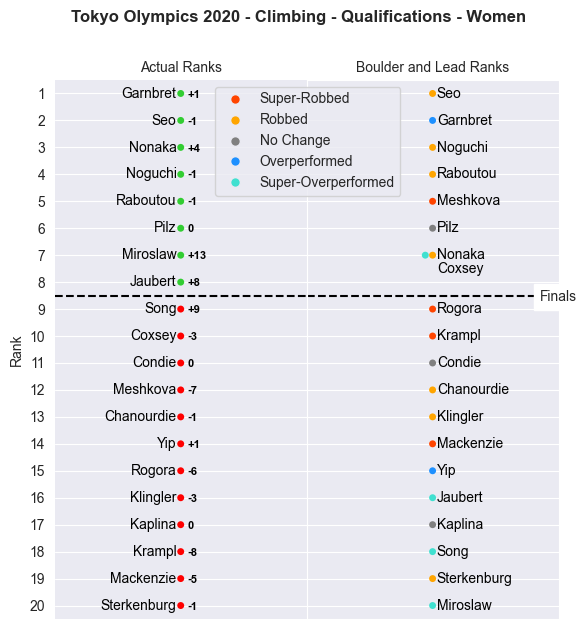

In [281]:
# Set the plot style to 'whitegrid'
sns.set_style('darkgrid')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 7), sharey=True)

# Plot the actual ranks on the left subplot
sns.swarmplot(data=tokyo_2020_boulder_and_lead_quali, y='qualification_actual_rank', ax=ax1, hue='qualified', palette=cmap_qualified)
for i, row in tokyo_2020_boulder_and_lead_quali.iterrows():
    ax1.annotate(row['Athlete Last Name'], (0,row['qualification_actual_rank']), textcoords="offset points", xytext=(-3, -3), ha='right', color='black')

# Set the labels and title for the left subplot
ax1.set_ylabel('Rank')
ax1.set_title('Actual Ranks', fontsize = 10)
# Remove the legend for the first chart
ax1.legend_.remove()
# Remove the box around the left subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Plot the predicted ranks on the right subplot
sns.swarmplot(data=tokyo_2020_boulder_and_lead_quali, y='qualification_B&L_recalculated_rank', ax=ax2,  hue='color', palette=cmap_rank_differences)
    # if some points (athletes ex aequo) we need to offset the names the displayed
temp_list_ranks = []
xytext_name_normal = (3,-3)
xytext_name_offset = (3, -13)
xytext_rankdiff_normal = (5,-3)

for i, row in tokyo_2020_boulder_and_lead_quali.iterrows():
    ax2.annotate(row['Athlete Last Name'], (0,row['qualification_B&L_recalculated_rank']), textcoords="offset points", xytext= xytext_name_offset if row['qualification_B&L_recalculated_rank'] in temp_list_ranks else xytext_name_normal ,\
                  ha='left', color='black')
    ax1.annotate(row['rank_difference_text'], (0,row['qualification_actual_rank']), textcoords="offset points", xytext= xytext_rankdiff_normal ,\
                  ha='left', color='black', fontsize=8, fontweight = 'bold')
    temp_list_ranks.append(row['qualification_B&L_recalculated_rank'])

del temp_list_ranks

# Set the labels and title for the right subplot
ax2.set_title('Boulder and Lead Ranks', fontsize = 10)
# Move the legend box more to the left
ax2.legend(title='', handles=legend_circles, bbox_to_anchor=(0.4, 1))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

# Add a horizontal dashed line at y = 3.5 with the annotation "podium"
for ax in [ax1, ax2]:
    ax.axhline(y=8.5, color='black', linestyle='--')
    
ax2.text(0.5, 8.55, 'Finals', ha='center', va='center', backgroundcolor='white')

# Reverse the order of the y-axis
ax1.set_ylim(20.5,0.5)
ax2.set_ylim(20.5,0.5)

# Force the y tick marks to be set at every integer
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Show the plot
#plt.tight_layout()
title = 'Tokyo Olympics 2020 - Climbing - Qualifications - Women'
plt.suptitle(title, fontsize = 12, fontweight = 'bold')
plt.show()
fig.savefig(title)

In [274]:
# Visualizing an example, the Tokyo 2020 Olympics finals, and calculating what whould have been the final results with boulder and lead score rules

# Get the events of the olympics comp
tokyo_2020_men = ifsc_df_summary[ifsc_df_summary['Competition'].isin(['Olympics Tokyo 2021 - Qualifications - Men','Olympics Tokyo 2021 - Finals - Men'])].copy()
# Keep the columns needed and group by athlete
tokyo_2020_men_boulder_and_lead = tokyo_2020_men.drop(['Competition','Type','actual_rank','score_qualification_B&L', 'score_sf_B&L','score_final_B&L', 'year',],axis=1)
tokyo_2020_men_boulder_and_lead = tokyo_2020_men_boulder_and_lead.groupby(['Athlete First Name','Athlete Last Name']).sum().reset_index()

# Compute the B&L scores 
tokyo_2020_men_boulder_and_lead['qualification_B&L_recalculated'] = tokyo_2020_men_boulder_and_lead['qualification_boulder_converted_score'] + tokyo_2020_men_boulder_and_lead['qualification_lead_converted_score']
tokyo_2020_men_boulder_and_lead['final_B&L_recalculated'] = tokyo_2020_men_boulder_and_lead['final_boulder_converted_score'] + tokyo_2020_men_boulder_and_lead['final_lead_converted_score']
# Drop the unnecessary sf columns  
tokyo_2020_men_boulder_and_lead = tokyo_2020_men_boulder_and_lead.drop(['sf_boulder_converted_score', 'sf_lead_converted_score'],axis=1)
# Compute the ranks for quali 
tokyo_2020_men_boulder_and_lead['qualification_B&L_recalculated_rank'] = tokyo_2020_men_boulder_and_lead['qualification_B&L_recalculated'].rank(ascending=False).astype(int)
# Compute ranks for the final
tokyo_2020_men_boulder_and_lead['final_B&L_recalculated_rank'] = np.nan
tokyo_2020_men_boulder_and_lead_rank_mask = (tokyo_2020_men_boulder_and_lead['final_B&L_recalculated'] != 0) & (tokyo_2020_men_boulder_and_lead['final_B&L_recalculated'].notnull())
tokyo_2020_men_boulder_and_lead.loc[tokyo_2020_men_boulder_and_lead_rank_mask, 'final_B&L_recalculated_rank'] = tokyo_2020_men_boulder_and_lead.loc[tokyo_2020_men_boulder_and_lead_rank_mask, 'final_B&L_recalculated'].rank(ascending=False).astype(int)

# Manually creating the actual classification of the olympics
tokyo_2020_men_actual_classification = tokyo_2020_men[['Athlete First Name','Athlete Last Name']].groupby(['Athlete First Name','Athlete Last Name']).min().reset_index()
tokyo_2020_men_actual_classification['qualification_actual_rank'] = [5,6,13,9,7,10,16,3,4,12,18,19,15,1,8,14,11,17,20,2]
tokyo_2020_men_actual_classification['final_actual_rank'] = [6,1,np.nan,np.nan,8,np.nan,np.nan,7,3,np.nan,np.nan,np.nan,np.nan,5,2,np.nan,np.nan,np.nan,np.nan,4]

# Adding the actual ranks of the olympics to our df
tokyo_2020_men_boulder_and_lead = tokyo_2020_men_boulder_and_lead.merge(tokyo_2020_men_actual_classification,on=['Athlete First Name','Athlete Last Name'])

# Displaying results of quali
tokyo_2020_men_columns_for_quali = ['Athlete First Name', 'Athlete Last Name','qualification_boulder_converted_score','qualification_lead_converted_score','qualification_B&L_recalculated','qualification_B&L_recalculated_rank','qualification_actual_rank']
tokyo_2020_men_boulder_and_lead_quali = tokyo_2020_men_boulder_and_lead[tokyo_2020_men_columns_for_quali].sort_values(by='qualification_B&L_recalculated_rank', ascending = True)

# Adding the rank difference, color coding them and adding the medal color for final actual placement
tokyo_2020_men_boulder_and_lead_quali['rank_difference'] = tokyo_2020_men_boulder_and_lead_quali['qualification_B&L_recalculated_rank'] - tokyo_2020_men_boulder_and_lead_quali['qualification_actual_rank']
# Formatting the rank difference with a +/- sign for display
tokyo_2020_men_boulder_and_lead_quali['rank_difference_text'] = tokyo_2020_men_boulder_and_lead_quali['rank_difference'].apply(lambda x: f"+{x}" if x > 0 else str(x))
    # Define a color map for the rank differences
cmap_rank_differences = {'Super-Robbed': 'orangered', 'Robbed': 'orange', 'Overperformed': 'dodgerblue','Super-Overperformed': 'turquoise', 'No change': 'grey'}
    # Assign colors based on the rank differences
tokyo_2020_men_boulder_and_lead_quali['color'] = np.where(tokyo_2020_men_boulder_and_lead_quali['rank_difference'] < -3, 'Super-Robbed',\
                                                      np.where(tokyo_2020_men_boulder_and_lead_quali['rank_difference'] < 0, 'Robbed',\
                                                                np.where(tokyo_2020_men_boulder_and_lead_quali['rank_difference'] == 0, 'No change',\
                                                                np.where(tokyo_2020_men_boulder_and_lead_quali['rank_difference'] < 4, 'Overperformed', 'Super-Overperformed'))))
    # Assign medals based on the actual ranks
tokyo_2020_men_boulder_and_lead_quali['qualified'] = np.where(tokyo_2020_men_boulder_and_lead_quali['qualification_actual_rank'] <= 8, 'qualified', 'not_qualified')
    # Define a color map for the medals
cmap_qualified = {'qualified': 'limegreen', 'not_qualified': 'red'}

tokyo_2020_men_boulder_and_lead_quali.head()

,Athlete First Name,Athlete Last Name,qualification_boulder_converted_score,qualification_lead_converted_score,qualification_B&L_recalculated,qualification_B&L_recalculated_rank,qualification_actual_rank,rank_difference,rank_difference_text,color,qualified
7,Colin,Duffy,47.5,96.0,143.5,1,3,-2,-2,Robbed,qualified
0,Adam,Ondra,58.7,84.0,142.7,2,5,-3,-3,Robbed,qualified
8,Jakob,Schubert,43.9,96.0,139.9,3,4,-1,-1,Robbed,qualified
13,Mickael,Mawem M.,84.8,45.0,129.8,4,1,3,+3,Overperformed,qualified
14,Nathaniel,Coleman,44.4,84.0,128.4,5,8,-3,-3,Robbed,qualified


In [275]:
# Displaying results of final
tokyo_2020_men_columns_for_final = ['Athlete First Name', 'Athlete Last Name','final_boulder_converted_score','final_lead_converted_score','final_B&L_recalculated','final_B&L_recalculated_rank','final_actual_rank']
tokyo_2020_men_boulder_and_lead_final = tokyo_2020_men_boulder_and_lead[~tokyo_2020_men_boulder_and_lead['final_actual_rank'].isnull()][tokyo_2020_men_columns_for_final].sort_values(by='final_B&L_recalculated_rank', ascending = True)
tokyo_2020_men_boulder_and_lead_final['final_B&L_recalculated_rank'] = tokyo_2020_men_boulder_and_lead_final['final_B&L_recalculated_rank'].astype(int)
tokyo_2020_men_boulder_and_lead_final['final_actual_rank'] = tokyo_2020_men_boulder_and_lead_final['final_actual_rank'].astype(int)
tokyo_2020_men_boulder_and_lead_final[tokyo_2020_men_columns_for_final].sort_values(by='final_B&L_recalculated_rank', ascending = True)

# Adding the rank difference, color coding them and adding the medal color for final actual placement
tokyo_2020_men_boulder_and_lead_final['rank_difference'] = tokyo_2020_men_boulder_and_lead_final['final_B&L_recalculated_rank'] - tokyo_2020_men_boulder_and_lead_final['final_actual_rank']
# Formatting the rank difference with a +/- sign for display
tokyo_2020_men_boulder_and_lead_final['rank_difference_text'] = tokyo_2020_men_boulder_and_lead_final['rank_difference'].apply(lambda x: f"+{x}" if x > 0 else str(x))

    # Assign colors based on the rank differences
tokyo_2020_men_boulder_and_lead_final['color'] = np.where(tokyo_2020_men_boulder_and_lead_final['rank_difference'] < -3, 'Super-Robbed',\
                                                      np.where(tokyo_2020_men_boulder_and_lead_final['rank_difference'] < 0, 'Robbed',\
                                                                np.where(tokyo_2020_men_boulder_and_lead_final['rank_difference'] == 0, 'No change',\
                                                                np.where(tokyo_2020_men_boulder_and_lead_final['rank_difference'] < 4, 'Overperformed', 'Super-Overperformed'))))
    # Assign medals based on the actual ranks
tokyo_2020_men_boulder_and_lead_final['medal'] = np.where(tokyo_2020_men_boulder_and_lead_final['final_actual_rank'] == 1, 'gold', np.where(tokyo_2020_men_boulder_and_lead_final['final_actual_rank'] == 2, 'silver', np.where(tokyo_2020_men_boulder_and_lead_final['final_actual_rank'] == 3, 'bronze', 'no_medal')))
    # Define a color map for the medals
cmap_medals = {'gold': 'gold', 'silver': 'silver', 'bronze':'brown', 'no_medal': 'black'}

tokyo_2020_men_boulder_and_lead_final

,Athlete First Name,Athlete Last Name,final_boulder_converted_score,final_lead_converted_score,final_B&L_recalculated,final_B&L_recalculated_rank,final_actual_rank,rank_difference,rank_difference_text,color,medal
8,Jakob,Schubert,44.6,100.0,144.6,1,3,-2,-2,Robbed,bronze
7,Colin,Duffy,44.8,88.0,132.8,2,7,-5,-5,Super-Robbed,no_medal
0,Adam,Ondra,34.9,96.0,130.9,3,6,-3,-3,Robbed,no_medal
14,Nathaniel,Coleman,59.7,64.0,123.7,4,2,2,+2,Overperformed,silver
1,Alberto,Gines Lopez,29.4,80.0,109.4,5,1,4,+4,Super-Overperformed,gold
19,Tomoa,Narasaki,44.8,60.0,104.8,6,4,2,+2,Overperformed,no_medal
13,Mickael,Mawem M.,45.0,30.0,75.0,7,5,2,+2,Overperformed,no_medal
4,Bassa,Mawem B.,30.3,0.0,30.3,8,8,0,0,No change,no_medal


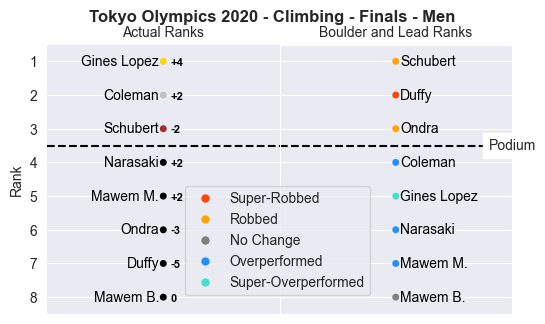

In [283]:
# Set the plot style to 'whitegrid'
sns.set_style('darkgrid')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.5), sharey=True)

# Plot the actual ranks on the left subplot
sns.swarmplot(data=tokyo_2020_men_boulder_and_lead_final, y='final_actual_rank', ax=ax1, hue='medal', palette=cmap_medals)
for i, row in tokyo_2020_men_boulder_and_lead_final.iterrows():
    ax1.annotate(row['Athlete Last Name'], (0,row['final_actual_rank']), textcoords="offset points", xytext=(-3, -3), ha='right', color='black')

# Set the labels and title for the left subplot
ax1.set_ylabel('Rank')
ax1.set_title('Actual Ranks', fontsize = 10)
# Remove the legend for the first chart
ax1.legend_.remove()
# Remove the box around the left subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Plot the predicted ranks on the right subplot
sns.swarmplot(data=tokyo_2020_men_boulder_and_lead_final, y='final_B&L_recalculated_rank', ax=ax2,  hue='color',palette=cmap_rank_differences)

    # if some points (athletes ex aequo) we need to offset the names the displayed
temp_list_ranks = []
for i, row in tokyo_2020_men_boulder_and_lead_final.iterrows():
    ax2.annotate(row['Athlete Last Name'], (0,row['final_B&L_recalculated_rank']), textcoords="offset points", xytext= xytext_name_offset if row['final_B&L_recalculated_rank'] in temp_list_ranks else xytext_name_normal ,\
                  ha='left', color='black')
    ax1.annotate(row['rank_difference_text'], (0,row['final_actual_rank']), textcoords="offset points", xytext=xytext_rankdiff_normal, ha='left', color='black',fontsize = 8, fontweight = 'bold')
    temp_list_ranks.append(row['final_B&L_recalculated_rank'])

del temp_list_ranks

# Set the labels and title for the right subplot
ax2.set_title('Boulder and Lead Ranks', fontsize = 10)

# Move the legend box more to the left
ax2.legend(title='',handles=legend_circles,  bbox_to_anchor=(0.42, 0.5))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

# Add a horizontal dashed line at y = 3.5 with the annotation "podium"
for ax in [ax1, ax2]:
    ax.axhline(y=3.5, color='black', linestyle='--')
    
ax2.text(0.5, 3.5, 'Podium', ha='center', va='center', backgroundcolor='white')

# Reverse the order of the y-axis
ax1.set_ylim(8.5,0.5)
ax2.set_ylim(8.5,0.5)

# Show the plot
#plt.tight_layout()
title = 'Tokyo Olympics 2020 - Climbing - Finals - Men'
plt.suptitle(title, fontsize = 12, fontweight = 'bold')
plt.show()
fig.savefig(title)

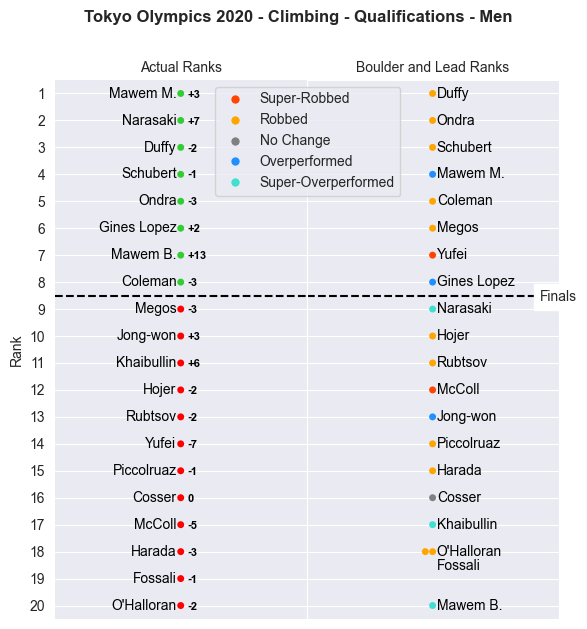

In [282]:
# Set the plot style to 'whitegrid'
sns.set_style('darkgrid')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 7), sharey=True)

# Plot the actual ranks on the left subplot
sns.swarmplot(data=tokyo_2020_men_boulder_and_lead_quali, y='qualification_actual_rank', ax=ax1, hue='qualified', palette=cmap_qualified)
for i, row in tokyo_2020_men_boulder_and_lead_quali.iterrows():
    ax1.annotate(row['Athlete Last Name'], (0,row['qualification_actual_rank']), textcoords="offset points", xytext=(-3, -3), ha='right', color='black')

# Set the labels and title for the left subplot
ax1.set_ylabel('Rank')
ax1.set_title('Actual Ranks', fontsize = 10)
# Remove the legend for the first chart
ax1.legend_.remove()
# Remove the box around the left subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Plot the predicted ranks on the right subplot
sns.swarmplot(data=tokyo_2020_men_boulder_and_lead_quali, y='qualification_B&L_recalculated_rank', ax=ax2,  hue='color', palette=cmap_rank_differences)
    # if some points (athletes ex aequo) we need to offset the names the displayed
temp_list_ranks = []

for i, row in tokyo_2020_men_boulder_and_lead_quali.iterrows():
    ax2.annotate(row['Athlete Last Name'], (0,row['qualification_B&L_recalculated_rank']), textcoords="offset points", xytext= xytext_name_offset if row['qualification_B&L_recalculated_rank'] in temp_list_ranks else xytext_name_normal ,\
                  ha='left', color='black')
    ax1.annotate(row['rank_difference_text'], (0,row['qualification_actual_rank']), textcoords="offset points", xytext= xytext_rankdiff_normal ,\
                  ha='left', color='black', fontsize=8, fontweight = 'bold')
    temp_list_ranks.append(row['qualification_B&L_recalculated_rank'])

del temp_list_ranks

# Set the labels and title for the right subplot
ax2.set_title('Boulder and Lead Ranks', fontsize = 10)
# Move the legend box more to the left
ax2.legend(title='', handles=legend_circles, bbox_to_anchor=(0.4, 1))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

# Add a horizontal dashed line at y = 3.5 with the annotation "podium"
for ax in [ax1, ax2]:
    ax.axhline(y=8.5, color='black', linestyle='--')
    
ax2.text(0.5, 8.55, 'Finals', ha='center', va='center', backgroundcolor='white')

# Reverse the order of the y-axis
ax1.set_ylim(20.5,0.5)
ax2.set_ylim(20.5,0.5)

# Force the y tick marks to be set at every integer
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Show the plot
#plt.tight_layout()
title = 'Tokyo Olympics 2020 - Climbing - Qualifications - Men'
plt.suptitle(title, fontsize = 12, fontweight = 'bold')
plt.show()
fig.savefig(title)